In [65]:
import os
from pathlib import Path
import pickle

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from reg_dates import get_user_reg_date

#### Settings

In [66]:
FPATH_USERS_INFO = r'D:\WORK\zresult\members_info\putin_z_members.pkl'
FPATHS_Z = [r'D:\WORK\zresult\putin_z\avatars\putin_z_z']
GROUP_NAME = 'putin_z'
DIRPATH_WORK = r'D:\WORK\zresult\putin_z'

#time_interval = '2021_22'
time_interval = 'all'

USER_ID_RANGE_2021_22 = (6.82e8, 7.33e8)

#### Analyze users' info: active, last seen, has an avatar

In [67]:
#### Load users' info from disk
with open(FPATH_USERS_INFO, 'rb') as fid:
    users = pickle.load(fid)
    
if isinstance(users, list):
  users = {user['id']: user for user in users}  

In [68]:
#### Categorize the users

# All sampled users  
user_idx = list(users.keys())
user_idx = np.array(user_idx)

# Take subset of users
mask = ((user_idx > USER_ID_RANGE_2021_22[0]) & 
        (user_idx < USER_ID_RANGE_2021_22[1]))
if time_interval == '2021_22':
    user_idx = user_idx[mask]

# Active / inactive users
user_idx_active = [user_id for user_id in user_idx
                   if 'deactivated' not in users[user_id]]
user_idx_active = np.array(user_idx_active)

# Users who have avatars
user_idx_photo = [user_id for user_id in user_idx_active
                  if users[user_id]['has_photo'] == True]
user_idx_photo = np.array(user_idx_photo)

# Users with information about 'last seen' date
user_idx_last_seen = [user_id for user_id in user_idx_active
                      if 'last_seen' in users[user_id].keys()]
user_idx_last_seen = np.array(user_idx_last_seen)

# Dates at which users were last seen
last_seen_vec = {
    user_id: datetime.datetime.fromtimestamp(users[user_id]['last_seen']['time'])
    for user_id in user_idx_last_seen
}

# Users who were last seen after the beginning of the war
war_start_date = datetime.datetime.strptime('24-02-2022', '%d-%m-%Y').date()
user_idx_seen_during_war = [user_id for user_id in user_idx_last_seen
                            if last_seen_vec[user_id].date() >= war_start_date]
user_idx_seen_during_war = np.array(user_idx_seen_during_war)

# Users with avatars, who were last seen after the beginning of the war
user_idx_photo_seen_during_war = [
        user_id for user_id in user_idx_last_seen
        if users[user_id]['has_photo'] == True
        and last_seen_vec[user_id].date() >= war_start_date]
user_idx_photo_seen_during_war = np.array(user_idx_photo_seen_during_war)

# Count users
Nsampled = len(user_idx)
Nactive = len(user_idx_active)
Nphoto = len(user_idx_photo)

# Print summary
print(f'Total: {Nsampled}')
print(f'Active: {Nactive}, {Nactive / Nsampled : .02f}')
print(f'With photo: {Nphoto}, {Nphoto / Nactive : .02f}')

Total: 270034
Active: 270034,  1.00
With photo: 253758,  0.94


#### Find users with Z-avatars

In [69]:
# Get indices of z-users from filenames
files = []
for fpath in FPATHS_Z:
    files += os.listdir(fpath)
user_idx_z = np.array([int(fname[:-4]) for fname in files])

# Z-users who was seen during the war
user_idx_z_seen_during_war = [user_id for user_id in user_idx_z
                              if user_id in user_idx_photo_seen_during_war]
user_idx_z_seen_during_war = np.array(user_idx_z_seen_during_war)

# Check that all z-users were active during the war
for user_id in user_idx_z:
    if ((user_id in user_idx_last_seen) and
        (user_id not in user_idx_seen_during_war)):
        last_seen = last_seen_vec[user_id]
        print(f'Z-user {user_id} was last seen {last_seen}')

#### Calculate user disributions by their registration dates

In [70]:
#### Calculate histograms

# Histograms: all, active
nbins = 50
h_all, hbins = np.histogram(user_idx, nbins)
h_active, _ = np.histogram(user_idx_active, hbins)
h_all_norm = h_all / np.sum(h_all)
h_active_norm = h_active / np.sum(h_active)

# Histogram and percentage of users having avatars
h_photo, _ = np.histogram(user_idx_photo, hbins)
perc_photo_act = h_photo / h_active

# Histogram and percentage of users seen during the war
h_last_seen, _ = np.histogram(user_idx_last_seen, hbins)
h_war, _ = np.histogram(user_idx_seen_during_war, hbins)
h_war_photo, _ = np.histogram(user_idx_photo_seen_during_war, hbins)
perc_lastseen_act = h_last_seen / h_active
perc_warphoto_photo = h_war_photo / h_photo

# Histogram of z-users
h_z, _ = np.histogram(user_idx_z, hbins)
h_war_z, _ = np.histogram(user_idx_z_seen_during_war, hbins)
perc_z_photo = h_z / h_photo
perc_warz_warphoto = h_war_z / h_war_photo

In [71]:
#### Convert histogram bins from user idx to dates

# Remap user idx to registration dates
need_get_reg_dates = False

fpath_reg_dates = Path(DIRPATH_WORK) / f'reg_dates_{time_interval}.csv'

if need_get_reg_dates:
    # User ID -> Rregistration date
    hbins_t = []
    for hbin in tqdm(hbins):
        hbins_t.append(get_user_reg_date(int(hbin)))
    hbins_t = np.asarray(hbins_t)

    # Fill None's
    hbins_tfix = hbins_t.copy()
    for n in range(1, len(hbins_t) - 1):
        if hbins_t[n] is None:        
            tvec_L = np.flip(hbins_t[:n])
            tvec_R = hbins_t[(n + 1):]        
            kL = np.argwhere(tvec_L != None)[0][0]
            kR = np.argwhere(tvec_R != None)[0][0]        
            nL = n - kL - 1
            nR = n + kR + 1        
            alpha = (hbins[n] - hbins[nL]) / (hbins[nR] - hbins[nL])
            tc = hbins_t[nL] + alpha * (hbins_t[nR] - hbins_t[nL])
            hbins_tfix[n] = tc
    hbins_t = hbins_tfix

    # Save ID-date mapping
    df = pd.DataFrame({'ID': hbins.astype(int), 'reg_date': hbins_t})
    df.to_csv(fpath_reg_dates, index=False)

else:
    # Load the existing ID-date mapping
    df = pd.read_csv(fpath_reg_dates, parse_dates=['reg_date'])
    hbins_t = df['reg_date'].to_numpy()
    #hbins_t = np.array([datetime.date.fromisoformat(d) for d in hbins_t])

    # Check user ID consistency
    hbins_loaded = df['ID'].to_numpy()
    if not np.all(hbins_loaded == hbins.astype(int)):
        raise ValueError('Loaded user IDs are inconsistent with histogram bins')

#### Visualize the results

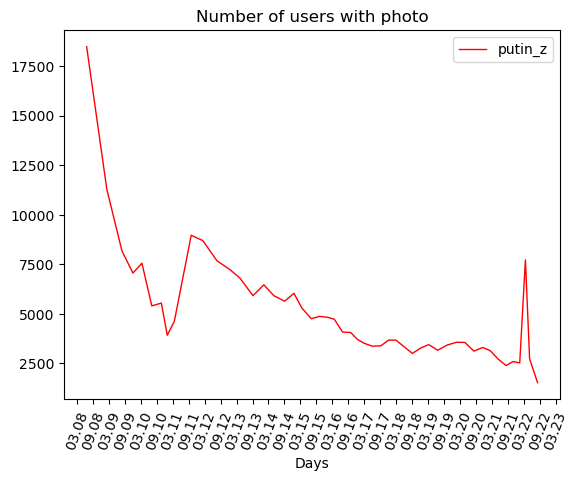

In [72]:
def smooth(y, kernel_sz):
    #K = np.ones(kernel_sz)
    K = np.hanning(kernel_sz + 2)[1 : -1]
    K = K / np.sum(K)
    y_smooth = np.convolve(y, K, mode='same')
    return y_smooth
    
def plot_with_dates(tvec, xvec, title_str, label, style='-', linewidth=1):
    ax = plt.gca()
    plt.xticks(rotation=70)
    plt.plot([], [])
    plt.plot(tvec, xvec, style, linewidth=linewidth, label=label)
    plt.xlabel('Days')
    plt.legend()
    plt.title(title_str)
    if time_interval == '2021_22':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))
    

perc_z_photo[np.isnan(perc_z_photo)] = 0
perc_warz_warphoto[np.isnan(perc_warz_warphoto)] = 0

#col = 'b'
col = 'r'

# Plot number of users with photo
plot_with_dates(hbins_t[1:], h_photo, style=f'{col}', linewidth=1,
                title_str='Number of users with photo', label=GROUP_NAME)